In [1]:
# import libraries
import pandas as pd
import numpy as np
import sys
import sklearn
import io
import random
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
## add the columns' name and read the KDDTrain+ and KDDTest+ datasets
col_names = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label"]


df = pd.read_csv("NSL_KDD_Train.csv",header=None, names = col_names)

df_test = pd.read_csv("NSL_KDD_Test.csv", header=None, names = col_names)

#df_test_21 = pd.read_csv("NSL_KDD_Test_21.csv", header=None, names = col_names)

print('Dimensions of the Training set:',df.shape)
print('Dimensions of the Test set:',df_test.shape)
#print('Dimensions of the Test_21 set:',df_test_21.shape)

Dimensions of the Training set: (125973, 42)
Dimensions of the Test set: (22544, 42)


In [3]:
# review the features type
df.head(5) 

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [4]:
print('Label distribution in the Training set:')
print("****************************************")
print(df['label'].value_counts())
print('\n')
print('Label distribution in the Test set:')
print("**************************************")
print(df_test['label'].value_counts())

Label distribution in the Training set:
****************************************
normal             67343
neptune            41214
satan               3633
ipsweep             3599
portsweep           2931
smurf               2646
nmap                1493
back                 956
teardrop             892
warezclient          890
pod                  201
guess_passwd          53
buffer_overflow       30
warezmaster           20
land                  18
imap                  11
rootkit               10
loadmodule             9
ftp_write              8
multihop               7
phf                    4
perl                   3
spy                    2
Name: label, dtype: int64


Label distribution in the Test set:
**************************************
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
s

In [5]:
# columns are categorical, not yet binary: protocol_type (column 2), service (column 3), flag (column 4).
print('Training set:')
for col_name in df.columns:
    if df[col_name].dtypes == 'object' :
        unique_cat = len(df[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))

print()
print('Distribution of categories in service:')
print(df['service'].value_counts().sort_values(ascending=False).head())

Training set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 70 categories
Feature 'flag' has 11 categories
Feature 'label' has 23 categories

Distribution of categories in service:
http        40338
private     21853
domain_u     9043
smtp         7313
ftp_data     6860
Name: service, dtype: int64


In [6]:
# Test set
print('Test set:')
for col_name in df_test.columns:
    if df_test[col_name].dtypes == 'object' :
        unique_cat = len(df_test[col_name].unique())
        print("Feature '{col_name}' has {unique_cat} categories".format(col_name=col_name, unique_cat=unique_cat))


Test set:
Feature 'protocol_type' has 3 categories
Feature 'service' has 64 categories
Feature 'flag' has 11 categories
Feature 'label' has 38 categories


In [7]:
categorical_columns=['protocol_type', 'service', 'flag']

df_categorical_values = df[categorical_columns]
# for Test
testdf_categorical_values = df_test[categorical_columns]

# protocol type
unique_protocol=sorted(df.protocol_type.unique())
string1 = 'Protocol_type_'
unique_protocol2=[string1 + x for x in unique_protocol]
print(unique_protocol2)

# service
unique_service=sorted(df.service.unique())
string2 = 'service_'
unique_service2=[string2 + x for x in unique_service]
print(unique_service2)


# flag
unique_flag=sorted(df.flag.unique())
string3 = 'flag_'
unique_flag2=[string3 + x for x in unique_flag]
print(unique_flag2)


# put together
dumcols=unique_protocol2 + unique_service2 + unique_flag2


#do it for test set
unique_service_test=sorted(df_test.service.unique())
unique_service2_test=[string2 + x for x in unique_service_test]
testdumcols=unique_protocol2 + unique_service2_test + unique_flag2


['Protocol_type_icmp', 'Protocol_type_tcp', 'Protocol_type_udp']
['service_IRC', 'service_X11', 'service_Z39_50', 'service_aol', 'service_auth', 'service_bgp', 'service_courier', 'service_csnet_ns', 'service_ctf', 'service_daytime', 'service_discard', 'service_domain', 'service_domain_u', 'service_echo', 'service_eco_i', 'service_ecr_i', 'service_efs', 'service_exec', 'service_finger', 'service_ftp', 'service_ftp_data', 'service_gopher', 'service_harvest', 'service_hostnames', 'service_http', 'service_http_2784', 'service_http_443', 'service_http_8001', 'service_imap4', 'service_iso_tsap', 'service_klogin', 'service_kshell', 'service_ldap', 'service_link', 'service_login', 'service_mtp', 'service_name', 'service_netbios_dgm', 'service_netbios_ns', 'service_netbios_ssn', 'service_netstat', 'service_nnsp', 'service_nntp', 'service_ntp_u', 'service_other', 'service_pm_dump', 'service_pop_2', 'service_pop_3', 'service_printer', 'service_private', 'service_red_i', 'service_remote_job', 'ser

In [8]:
df_categorical_values_enc=df_categorical_values.apply(LabelEncoder().fit_transform)
print(df_categorical_values.head())
print('--------------------')
print(df_categorical_values_enc.head())
# test set
testdf_categorical_values_enc=testdf_categorical_values.apply(LabelEncoder().fit_transform)

  protocol_type   service flag
0           tcp  ftp_data   SF
1           udp     other   SF
2           tcp   private   S0
3           tcp      http   SF
4           tcp      http   SF
--------------------
   protocol_type  service  flag
0              1       20     9
1              2       44     9
2              1       49     5
3              1       24     9
4              1       24     9


In [9]:
enc = OneHotEncoder(categories='auto')
df_categorical_values_encenc = enc.fit_transform(df_categorical_values_enc)
df_cat_data = pd.DataFrame(df_categorical_values_encenc.toarray(),columns=dumcols)
# test set
testdf_categorical_values_encenc = enc.fit_transform(testdf_categorical_values_enc)
testdf_cat_data = pd.DataFrame(testdf_categorical_values_encenc.toarray(),columns=testdumcols)

trainservice=df['service'].tolist()
testservice= df_test['service'].tolist()
difference=list(set(trainservice) - set(testservice))
string = 'service_'
difference=[string + x for x in difference]

for col in difference:
    testdf_cat_data[col] = 0

print(df_cat_data.shape)    
print(testdf_cat_data.shape)

(125973, 84)
(22544, 84)


In [10]:
newdf=df.join(df_cat_data)
newdf.drop('flag', axis=1, inplace=True)
newdf.drop('protocol_type', axis=1, inplace=True)
newdf.drop('service', axis=1, inplace=True)

# test data
newdf_test=df_test.join(testdf_cat_data)
newdf_test.drop('flag', axis=1, inplace=True)
newdf_test.drop('protocol_type', axis=1, inplace=True)
newdf_test.drop('service', axis=1, inplace=True)

print(newdf.shape)
print(newdf_test.shape)

(125973, 123)
(22544, 123)


In [11]:
# step1: apply the logarithmic scaling method for scaling to obtain the ranges of `duration[0,4.77]', `src_bytes[0,9.11]' and `dst_bytes[0,9.11]
newdf['log2_value1'] = np.log2(newdf['duration'])
newdf['log2_value2'] = np.log(newdf['src_bytes'])
newdf['log2_value3'] = np.log(newdf['dst_bytes'])
newdf=newdf.drop(['log2_value3','log2_value2','log2_value1'], axis=1)


# testing set

newdf_test['log2_value1'] = np.log2(newdf_test['duration'])
newdf_test['log2_value2'] = np.log(newdf_test['src_bytes'])
newdf_test['log2_value3'] = np.log(newdf_test['dst_bytes'])
newdf_test=newdf_test.drop(['log2_value3','log2_value2','log2_value1'], axis=1)

print(newdf)
print(newdf_test)

        duration  src_bytes  dst_bytes  land  wrong_fragment  urgent  hot  \
0              0        491          0     0               0       0    0   
1              0        146          0     0               0       0    0   
2              0          0          0     0               0       0    0   
3              0        232       8153     0               0       0    0   
4              0        199        420     0               0       0    0   
...          ...        ...        ...   ...             ...     ...  ...   
125968         0          0          0     0               0       0    0   
125969         8        105        145     0               0       0    0   
125970         0       2231        384     0               0       0    0   
125971         0          0          0     0               0       0    0   
125972         0        151          0     0               0       0    0   

        num_failed_logins  logged_in  num_compromised  ...  flag_REJ  \
0  

/Users/suyadanawin/anaconda3/envs/testing/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/suyadanawin/anaconda3/envs/testing/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/suyadanawin/anaconda3/envs/testing/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/suyadanawin/anaconda3/envs/testing/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/suyadanawin/anaconda3/envs/testing/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, metho

In [12]:
labeldf=newdf['label']
labeldf_test=newdf_test['label']


# change the label column
newlabeldf=labeldf.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                           'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})
newlabeldf_test=labeldf_test.replace({ 'normal' : 0, 'neptune' : 1 ,'back': 1, 'land': 1, 'pod': 1, 'smurf': 1, 'teardrop': 1,'mailbomb': 1, 'apache2': 1, 'processtable': 1, 'udpstorm': 1, 'worm': 1,
                           'ipsweep' : 2,'nmap' : 2,'portsweep' : 2,'satan' : 2,'mscan' : 2,'saint' : 2
                           ,'ftp_write': 3,'guess_passwd': 3,'imap': 3,'multihop': 3,'phf': 3,'spy': 3,'warezclient': 3,'warezmaster': 3,'sendmail': 3,'named': 3,'snmpgetattack': 3,'snmpguess': 3,'xlock': 3,'xsnoop': 3,'httptunnel': 3,
                            'buffer_overflow': 4,'loadmodule': 4,'perl': 4,'rootkit': 4,'ps': 4,'sqlattack': 4,'xterm': 4})



#put the new label column back
newdf['label'] = newlabeldf
newdf_test['label'] = newlabeldf_test

In [13]:
#Split the test and train data into training and testing 
# train set:
x=newdf.drop(["label"],1)  # features
y=newlabeldf  # label
# test set:
xtest=newdf_test.drop(['label'],1) # features
ytest=newlabeldf_test # label

/var/folders/7y/7nszfn8x6zz3sq063xldyl9h0000gn/T/ipykernel_23389/1207078613.py:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  x=newdf.drop(["label"],1)  # features
/var/folders/7y/7nszfn8x6zz3sq063xldyl9h0000gn/T/ipykernel_23389/1207078613.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  xtest=newdf_test.drop(['label'],1) # features


In [14]:
# multi-class classification with Keras
# define baseline model
def baseline_model():
	# create model
	model = Sequential()
	model.add(Dense(80, input_dim=122, activation='relu'))
	model.add(Dense(5, activation='softmax'))
	# Compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
	return model
 
estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)
kfold = KFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator,x,y, cv=kfold)
print("Accuracy: %.2f%%" % (results.mean()*100))

/var/folders/7y/7nszfn8x6zz3sq063xldyl9h0000gn/T/ipykernel_23389/4252303200.py:12: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  estimator = KerasClassifier(build_fn=baseline_model, epochs=20, batch_size=5, verbose=0)
2023-04-27 05:14:16.564870: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Accuracy: 97.19%


In [15]:
to_drop_DoS = [0,1]
to_drop_Probe = [0,2]
to_drop_R2L = [0,3]
to_drop_U2R = [0,4]

# Filter all rows with label value except itself
# isin filter function

DoS_df=newdf[newdf['label'].isin(to_drop_DoS)];
Probe_df=newdf[newdf['label'].isin(to_drop_Probe)];
R2L_df=newdf[newdf['label'].isin(to_drop_R2L)];
U2R_df=newdf[newdf['label'].isin(to_drop_U2R)];



#test
DoS_df_test=newdf_test[newdf_test['label'].isin(to_drop_DoS)];
Probe_df_test=newdf_test[newdf_test['label'].isin(to_drop_Probe)];
R2L_df_test=newdf_test[newdf_test['label'].isin(to_drop_R2L)];
U2R_df_test=newdf_test[newdf_test['label'].isin(to_drop_U2R)];


print('Train Set:')
print('Dimensions of DoS:' ,DoS_df.shape)
print('Dimensions of Probe:' ,Probe_df.shape)
print('Dimensions of R2L:' ,R2L_df.shape)
print('Dimensions of U2R:' ,U2R_df.shape)
print()
print('Test Set:')
print('Dimensions of DoS:' ,DoS_df_test.shape)
print('Dimensions of Probe:' ,Probe_df_test.shape)
print('Dimensions of R2L:' ,R2L_df_test.shape)
print('Dimensions of U2R:' ,U2R_df_test.shape)

Train Set:
Dimensions of DoS: (113270, 123)
Dimensions of Probe: (78999, 123)
Dimensions of R2L: (68338, 123)
Dimensions of U2R: (67395, 123)

Test Set:
Dimensions of DoS: (17171, 123)
Dimensions of Probe: (12132, 123)
Dimensions of R2L: (12596, 123)
Dimensions of U2R: (9778, 123)


In [16]:
# Split dataframes into X & Y
# X Properties, Y result variable

X_DoS = DoS_df.drop('label',1)
Y_DoS = DoS_df.label

X_Probe = Probe_df.drop('label',1)
Y_Probe = Probe_df.label

X_R2L = R2L_df.drop('label',1)
Y_R2L = R2L_df.label

X_U2R = U2R_df.drop('label',1)
Y_U2R = U2R_df.label

# test set
X_DoS_test = DoS_df_test.drop('label',1)
Y_DoS_test = DoS_df_test.label

X_Probe_test = Probe_df_test.drop('label',1)
Y_Probe_test = Probe_df_test.label

X_R2L_test = R2L_df_test.drop('label',1)
Y_R2L_test = R2L_df_test.label

X_U2R_test = U2R_df_test.drop('label',1)
Y_U2R_test = U2R_df_test.label


/var/folders/7y/7nszfn8x6zz3sq063xldyl9h0000gn/T/ipykernel_23389/2924131433.py:4: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_DoS = DoS_df.drop('label',1)
/var/folders/7y/7nszfn8x6zz3sq063xldyl9h0000gn/T/ipykernel_23389/2924131433.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_Probe = Probe_df.drop('label',1)
/var/folders/7y/7nszfn8x6zz3sq063xldyl9h0000gn/T/ipykernel_23389/2924131433.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_R2L = R2L_df.drop('label',1)
/var/folders/7y/7nszfn8x6zz3sq063xldyl9h0000gn/T/ipykernel_23389/2924131433.py:13: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_U2R = U2R_df.drop('label',1)
/var/f

In [17]:
colNames=list(X_DoS)
colNames_test=list(X_DoS_test)

In [18]:
scaler1 = preprocessing.StandardScaler().fit(X_DoS)
X_DoS=scaler1.transform(X_DoS) 

scaler2 = preprocessing.StandardScaler().fit(X_Probe)
X_Probe=scaler2.transform(X_Probe)

scaler3 = preprocessing.StandardScaler().fit(X_R2L)
X_R2L=scaler3.transform(X_R2L)

scaler4 = preprocessing.StandardScaler().fit(X_U2R)
X_U2R=scaler4.transform(X_U2R) 

# test data
scaler5 = preprocessing.StandardScaler().fit(X_DoS_test)
X_DoS_test=scaler5.transform(X_DoS_test) 

scaler6 = preprocessing.StandardScaler().fit(X_Probe_test)
X_Probe_test=scaler6.transform(X_Probe_test) 

scaler7 = preprocessing.StandardScaler().fit(X_R2L_test)
X_R2L_test=scaler7.transform(X_R2L_test) 

scaler8 = preprocessing.StandardScaler().fit(X_U2R_test)
X_U2R_test=scaler8.transform(X_U2R_test)

**Compartive Machine learning Models:**

**DoS**

DoS
     Accuracy Score
MLP        0.903092
SVM        0.868907
J48        0.834314
NB         0.769087
RF         0.654476




Text(0.5, 0, 'DoS')

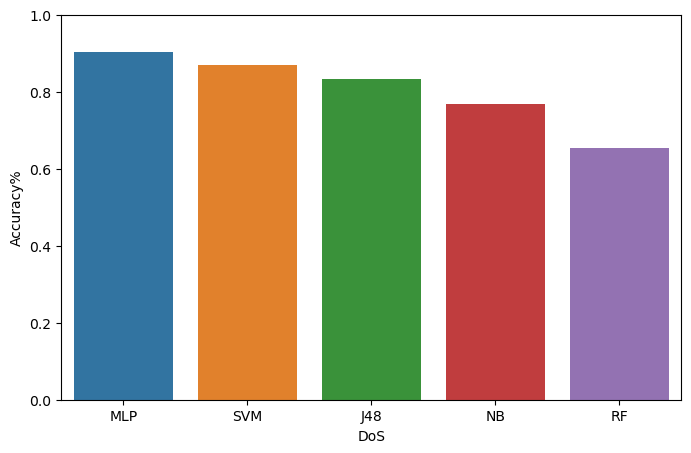

In [21]:
#1. DoS
import matplotlib.pyplot as plt
import seaborn as sns
mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model = value
    model.fit(X_DoS, Y_DoS.astype(int))
    scores[key] = model.score(X_DoS_test , Y_DoS_test)

# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('DoS')
print(scores_frame)
print("\n")

plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("DoS")

**Probe**

Probe
     Accuracy Score
MLP        0.902819
RF         0.894659
SVM        0.876690
J48        0.395648
NB         0.189252




Text(0.5, 0, 'Probe')

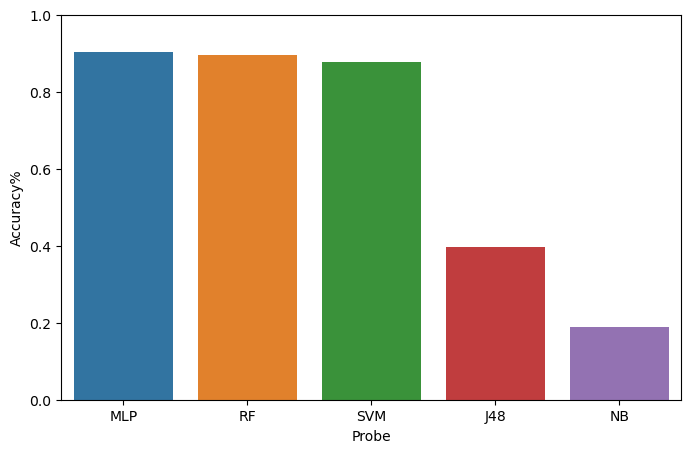

In [22]:
# 2.Probe
mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model1 = value
    model1.fit(X_Probe, Y_Probe.astype(int))
    scores[key] = model1.score(X_Probe_test , Y_Probe_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('Probe')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("Probe")

R2L
     Accuracy Score
MLP        0.775087
SVM        0.771038
J48        0.770959
NB         0.770959
RF         0.770959




Text(0.5, 0, 'R2L')

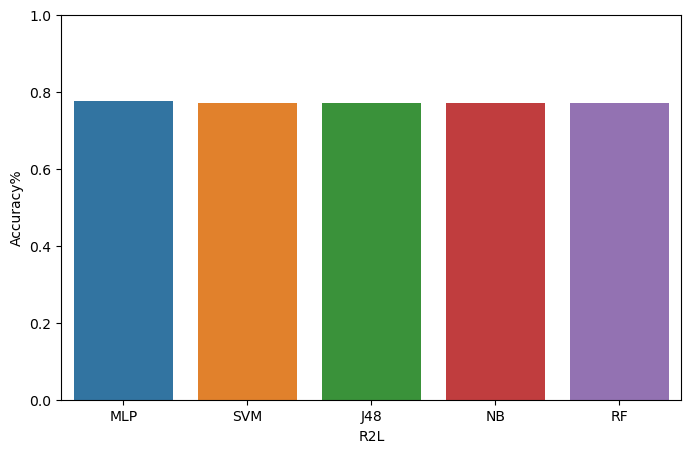

In [23]:
# 3.R2L
mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model2 = value
    model2.fit(X_R2L, Y_R2L.astype(int))
    scores[key] = model2.score(X_R2L_test , Y_R2L_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('R2L')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame["Accuracy Score"])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("R2L")

U2R
     Accuracy Score
MLP        0.993864
J48        0.993455
NB         0.993148
RF         0.993148
SVM        0.993148




Text(0.5, 0, 'U2R')

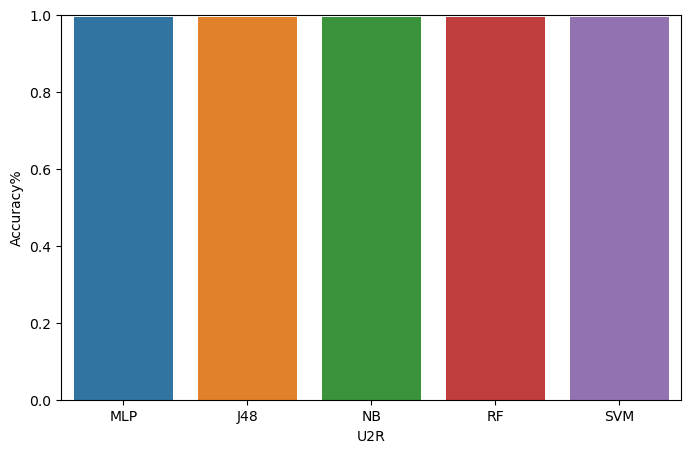

In [24]:
# 4.U2R
mlp = MLPClassifier(solver='adam', learning_rate_init = 0.0005, learning_rate = 'adaptive', activation="relu", max_iter=2000, random_state=42)
dec = DecisionTreeClassifier(criterion="entropy", max_depth=3)
ran = RandomForestClassifier(n_estimators=100)
svm = SVC(random_state=1)
naive = GaussianNB()

models = {"J48" : dec,
          "NB" : naive,
          "RF" : ran,
          "MLP" : mlp,
          "SVM" : svm
          }
scores= { }

for key, value in models.items():    
    model3 = value
    model3.fit(X_U2R, Y_U2R.astype(int))
    scores[key] = model3.score(X_U2R_test , Y_U2R_test)


# results
scores_frame = pd.DataFrame(scores, index=["Accuracy Score"]).T
scores_frame.sort_values(by=["Accuracy Score"], axis=0 ,ascending=False, inplace=True)
print('U2R')
print(scores_frame)
print('\n')
plt.figure(figsize=(8,5))
sns.barplot(x=scores_frame.index,y=scores_frame['Accuracy Score'])
plt.ylim(0, 1)
plt.ylabel("Accuracy%")
plt.xlabel("U2R")

In [25]:
# 1.DoS
Y_DoS_pred=model.predict(X_DoS_test)
# Create confusion matrix
print('Dos')
pd.crosstab(Y_DoS_test, Y_DoS_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Dos


Predicted attacks,0,1
Actual attacks,,
0,9546,165
1,2086,5374


In [26]:
#2.Probe
Y_Probe_pred=model1.predict(X_Probe_test)

# Create confusion matrix
print('Probe')
pd.crosstab(Y_Probe_test, Y_Probe_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

Probe


Predicted attacks,0,2
Actual attacks,,
0,9233,478
2,1018,1403


In [27]:
#3.R2L
Y_R2L_pred=model2.predict(X_R2L_test)
# Create confusion matrix
print('R2L')
pd.crosstab(Y_R2L_test, Y_R2L_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

R2L


Predicted attacks,0,3
Actual attacks,,
0,9710,1
3,2883,2


In [28]:
#4.U2R
Y_U2R_pred=model3.predict(X_U2R_test)
print('U2R')
# Create confusion matrix
pd.crosstab(Y_U2R_test, Y_U2R_pred, rownames=['Actual attacks'], colnames=['Predicted attacks'])

U2R


Predicted attacks,0
Actual attacks,
0,9711
4,67
